## Conclusion from SQL and panda pre analysis
### Observation
* The code of a control area is unique. A control area will only have one unit and multiple SCPs but units may be duplicate among stations. Linename is messy. => Just use Control Area
* Time is not consistent too. => Use morning/afternoon/night...
* Get needed columns to save almost 100 mb
* Can keep desc-recovered but will need to clean duplicate data with both regular and recovered
* SQL query may be faster

### Completed
* Query data from database
* Clean duplicate data with both regular and recovered
* Create datetime frame


### To do
* Substract entries and exits to get the numbers
* Clean data
* Substract entries and exits by time
* Time analysis

In [21]:
#*****need to run*****
from sqlalchemy import create_engine
#from sqlalchemy import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#*****need to run*****
engine = create_engine("sqlite:///mta.db")

In [3]:
#*****need to run*****
#df = pd.read_sql('SELECT ca, scp, station, date, time, desc, entries, exits FROM mta_data;', engine)
df = pd.read_sql('''SELECT ca, scp, station, date, time, desc, entries, exits FROM mta_data
                    WHERE date NOT IN ("02/27/2021", "02/28/2021", "06/01/2021", 
                                       "06/02/2021", "06/03/2021", "06/04/2021")
                    ORDER BY ca, date, time, scp, desc;''', engine)

In [4]:
#*****need to run*****
df["o_index"] = df.index
df["o_index"]
#drop duplicate data with wrong recover audit first
mask_dup = df[(df["o_index"] == 300706) |
          (df["o_index"] == 1089956) |
          (df["o_index"] == 1382146) |
          (df["o_index"] == 1382154) |
          ((df["CA"] == "N100") &
           (df["SCP"] == "00-00-00") &
           (df["ENTRIES"] == 818272) &
           (df["o_index"] != 842617))].index
df.drop(mask_dup, inplace= True)
#then, drop duplicate data with wrong regular data
df.drop_duplicates(subset=["CA", "SCP", "STATION", "DATE", "TIME"], keep= 'last', inplace=True)
df.drop(['o_index'], axis = 1, inplace = True)
df.reset_index(drop = True, inplace = True)
#datatime series
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df["DAY"] = df["DATE_TIME"].dt.weekday

In [5]:
df.sample(3)

,CA,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY
1385896,N528,01-00-01,EAST BROADWAY,04/12/2021,00:00:00,REGULAR,1380443,745562,2021-04-12,0
968347,N192,00-05-00,BEACH 60 ST,03/19/2021,00:00:00,REGULAR,117440934,0,2021-03-19,4
1973080,R192,00-00-01,MARBLE HILL-225,05/07/2021,00:00:00,REGULAR,357468,21347,2021-05-07,4


In [6]:
dup = (df
       .groupby(["CA", "SCP", "STATION", "DATE", "TIME"])
       .ENTRIES.count()
       .reset_index()
       .sort_values("ENTRIES"))
dup[dup.ENTRIES > 1].shape

(0, 6)

In [7]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747682 entries, 0 to 2747681
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   CA         2747682 non-null  object        
 1   SCP        2747682 non-null  object        
 2   STATION    2747682 non-null  object        
 3   DATE       2747682 non-null  object        
 4   TIME       2747682 non-null  object        
 5   DESC       2747682 non-null  object        
 6   ENTRIES    2747682 non-null  int64         
 7   EXITS      2747682 non-null  int64         
 8   DATE_TIME  2747682 non-null  datetime64[ns]
 9   DAY        2747682 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 209.6+ MB


In [8]:
for col in df:
    print(col, df[col].nunique())

CA 750
SCP 224
STATION 379
DATE 92
TIME 56818
DESC 2
ENTRIES 1806445
EXITS 1717079
DATE_TIME 174383
DAY 7


In [9]:
for col in df:
    print(df[col].value_counts())

PTH22    23551
R610     13798
PTH03    13540
PTH02    12173
R238     12130
         ...  
R177      1440
J022      1104
H037      1104
A085       552
OB01       313
Name: CA, Length: 750, dtype: int64
00-00-00    254821
00-00-01    253109
00-00-02    225010
00-00-03    113927
00-03-00     99554
             ...  
00-04-09       521
02-02-04       520
03-01-07       508
03-00-08         3
01-FF-02         1
Name: SCP, Length: 224, dtype: int64
34 ST-PENN STA     56364
FULTON ST          53013
GRD CNTRL-42 ST    49022
23 ST              40300
86 ST              36002
                   ...  
HARLEM 148 ST       1640
CHAUNCEY ST         1640
CLEVELAND ST        1104
SUTTER AV           1104
ORCHARD BEACH        313
Name: STATION, Length: 379, dtype: int64
04/12/2021    30321
03/19/2021    30167
03/16/2021    30147
04/07/2021    30094
03/15/2021    30073
              ...  
04/29/2021    29800
05/23/2021    29789
05/02/2021    29783
05/14/2021    29761
03/14/2021    27156
Name: DATE, Lengt

In [10]:
#*********must run*********
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.last())
#(df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.max())
daily_max = (df
             .groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
             .agg({"ENTRIES":"max", "EXITS":"max"})
             .rename(columns={"ENTRIES": "ENTRIES_MAX", "EXITS": "EXITS_MAX"}))
daily_max

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX
0,A002,02-00-00,59 ST,03/01/2021,7538400,2570968
1,A002,02-00-00,59 ST,03/02/2021,7538926,2571211
2,A002,02-00-00,59 ST,03/03/2021,7539503,2571472
3,A002,02-00-00,59 ST,03/04/2021,7540040,2571750
4,A002,02-00-00,59 ST,03/05/2021,7540626,2572022
...,...,...,...,...,...,...
459351,TRAM2,00-05-01,RIT-ROOSEVELT,05/27/2021,5554,577
459352,TRAM2,00-05-01,RIT-ROOSEVELT,05/28/2021,5554,577
459353,TRAM2,00-05-01,RIT-ROOSEVELT,05/29/2021,5554,577
459354,TRAM2,00-05-01,RIT-ROOSEVELT,05/30/2021,5554,577


In [11]:
#*********must run*********
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.first())
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.min())
daily_min = (df
             .groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
             .agg({"ENTRIES":"min", "EXITS":"min"})
             .rename(columns={"ENTRIES": "ENTRIES_MIN", "EXITS": "EXITS_MIN"}))
daily_min

,CA,SCP,STATION,DATE,ENTRIES_MIN,EXITS_MIN
0,A002,02-00-00,59 ST,03/01/2021,7537860,2570718
1,A002,02-00-00,59 ST,03/02/2021,7538409,2570969
2,A002,02-00-00,59 ST,03/03/2021,7538938,2571214
3,A002,02-00-00,59 ST,03/04/2021,7539514,2571474
4,A002,02-00-00,59 ST,03/05/2021,7540050,2571750
...,...,...,...,...,...,...
459351,TRAM2,00-05-01,RIT-ROOSEVELT,05/27/2021,5554,577
459352,TRAM2,00-05-01,RIT-ROOSEVELT,05/28/2021,5554,577
459353,TRAM2,00-05-01,RIT-ROOSEVELT,05/29/2021,5554,577
459354,TRAM2,00-05-01,RIT-ROOSEVELT,05/30/2021,5554,577


In [12]:
#*********must run*********
#SCP daily level
daily = pd.merge(daily_max, daily_min, on = ["CA", "SCP", "STATION", "DATE"])
daily["ENTRIES_DAILY"] = daily["ENTRIES_MAX"] - daily["ENTRIES_MIN"]
daily["EXITS_DAILY"] = daily["EXITS_MAX"] - daily["EXITS_MIN"]
daily["SUM_DAILY"] = daily["ENTRIES_DAILY"] + daily["EXITS_DAILY"]
daily["DATE"] = pd.to_datetime(daily.DATE, format="%m/%d/%Y")
daily["DAY"] = daily["DATE"].dt.weekday
daily

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY
0,A002,02-00-00,59 ST,2021-03-01,7538400,2570968,7537860,2570718,540,250,790,0
1,A002,02-00-00,59 ST,2021-03-02,7538926,2571211,7538409,2570969,517,242,759,1
2,A002,02-00-00,59 ST,2021-03-03,7539503,2571472,7538938,2571214,565,258,823,2
3,A002,02-00-00,59 ST,2021-03-04,7540040,2571750,7539514,2571474,526,276,802,3
4,A002,02-00-00,59 ST,2021-03-05,7540626,2572022,7540050,2571750,576,272,848,4
...,...,...,...,...,...,...,...,...,...,...,...,...
459351,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-27,5554,577,5554,577,0,0,0,3
459352,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-28,5554,577,5554,577,0,0,0,4
459353,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-29,5554,577,5554,577,0,0,0,5
459354,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-30,5554,577,5554,577,0,0,0,6


In [13]:
daily[daily["ENTRIES_DAILY"] < 0]

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY


In [14]:
daily[daily["EXITS_DAILY"] < 0]

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY


In [15]:
#*********must run*********
mask_outlier = daily[(daily["ENTRIES_DAILY"] < 0) |
                     (daily["EXITS_DAILY"] < 0) |
                     (daily["ENTRIES_DAILY"] > 30000) |
                     (daily["EXITS_DAILY"] > 30000)].index
daily.drop(mask_outlier, inplace= True)
daily.sort_values("SUM_DAILY", ascending=False)

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY
283334,PTH22,00-01-04,PATH NEW WTC,2021-03-05,26234,24186,45,222,26189,23964,50153,4
261642,PTH03,00-01-08,JOURNAL SQUARE,2021-04-23,27171,17555,1,0,27170,17555,44725,4
261641,PTH03,00-01-08,JOURNAL SQUARE,2021-04-22,26948,17489,1,0,26947,17489,44436,3
315867,R160,02-03-00,66 ST-LINCOLN,2021-04-25,28817,15367,13,3,28804,15364,44168,6
261635,PTH03,00-01-08,JOURNAL SQUARE,2021-04-16,26237,17112,1,0,26236,17112,43348,4
...,...,...,...,...,...,...,...,...,...,...,...,...
316159,R160,02-05-01,66 ST-LINCOLN,2021-05-11,0,927,0,927,0,0,0,1
316158,R160,02-05-01,66 ST-LINCOLN,2021-05-10,0,927,0,927,0,0,0,0
316157,R160,02-05-01,66 ST-LINCOLN,2021-05-09,0,927,0,927,0,0,0,6
316156,R160,02-05-01,66 ST-LINCOLN,2021-05-08,0,927,0,927,0,0,0,5


In [16]:
#*********must run*********
#CA daily level
ca_daily = (daily.groupby(["CA", "STATION", "DATE", "DAY"], as_index=False)
                 .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
ca_daily

,CA,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,A002,59 ST,2021-03-01,0,7494,4099,3395
1,A002,59 ST,2021-03-02,1,7845,4336,3509
2,A002,59 ST,2021-03-03,2,8219,4447,3772
3,A002,59 ST,2021-03-04,3,7982,4376,3606
4,A002,59 ST,2021-03-05,4,8045,4436,3609
...,...,...,...,...,...,...,...
68911,TRAM2,RIT-ROOSEVELT,2021-05-27,3,1975,1940,35
68912,TRAM2,RIT-ROOSEVELT,2021-05-28,4,1638,1608,30
68913,TRAM2,RIT-ROOSEVELT,2021-05-29,5,1347,1311,36
68914,TRAM2,RIT-ROOSEVELT,2021-05-30,6,1068,1029,39


In [17]:
#*********must run*********
#station daily level
station_daily = (daily.groupby(["STATION", "DATE", "DAY"], as_index=False)
                      .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
station_daily

,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,1 AV,2021-03-01,0,15040,5924,9116
1,1 AV,2021-03-02,1,15688,6085,9603
2,1 AV,2021-03-03,2,16251,6365,9886
3,1 AV,2021-03-04,3,16202,6290,9912
4,1 AV,2021-03-05,4,17031,6377,10654
...,...,...,...,...,...,...
34779,ZEREGA AV,2021-05-27,3,2347,1130,1217
34780,ZEREGA AV,2021-05-28,4,2218,1056,1162
34781,ZEREGA AV,2021-05-29,5,1138,531,607
34782,ZEREGA AV,2021-05-30,6,875,400,475


In [39]:
#station 3_month level
station_3_month = (daily.groupby(["STATION"], as_index=False)
                        .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
station_3_month.sort_values("SUM_DAILY", ascending=False)

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,6467822,2747128,3720694
59,34 ST-HERALD SQ,5161520,2194722,2966798
110,86 ST,4963336,2182962,2780374
233,GRD CNTRL-42 ST,4673949,1956992,2716957
9,125 ST,4583501,2067826,2515675
...,...,...,...,...
148,BEACH 98 ST,24142,10163,13979
354,TOMPKINSVILLE,22476,22476,0
141,BEACH 105 ST,13888,5046,8842
162,BROAD CHANNEL,12269,8386,3883


In [40]:
top_10_station = station_3_month.sort_values("SUM_DAILY", ascending=False).head(10)
top_10_station

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,6467822,2747128,3720694
59,34 ST-HERALD SQ,5161520,2194722,2966798
110,86 ST,4963336,2182962,2780374
233,GRD CNTRL-42 ST,4673949,1956992,2716957
9,125 ST,4583501,2067826,2515675
14,14 ST-UNION SQ,4518479,1856868,2661611
68,42 ST-PORT AUTH,4223261,1937073,2286188
46,23 ST,4089563,1889427,2200136
85,59 ST,3529918,1595818,1934100
226,FULTON ST,3514154,1535041,1979113


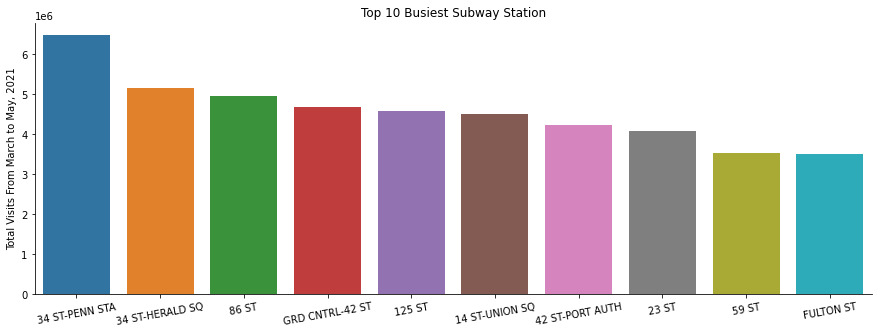

In [112]:
plt.figure(figsize=(15,5))
sns.barplot(x='STATION', y='SUM_DAILY', data=top_10_station)
plt.title("Top 10 Busiest Subway Station")
plt.xticks(fontsize = '10', rotation = 10)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("Total Visits From March to May, 2021", fontsize = '10')
sns.despine()
plt.savefig("top10_sum_daily_visit_staition.png", dpi = 200);

In [69]:
#Station avg
station_daily_avg = (station_daily.groupby(["STATION"], as_index=False)
                                  .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"mean", "EXITS_DAILY":"mean"})
                                  .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
top10_avg_staition = station_daily_avg.sort_values("AVG_DAILY", ascending=False).head(10)
top10_avg_staition

,STATION,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,70302.413043,29860.086957,40442.326087
59,34 ST-HERALD SQ,56103.478261,23855.673913,32247.804348
110,86 ST,53949.304348,23727.847826,30221.456522
233,GRD CNTRL-42 ST,50803.793478,21271.652174,29532.141304
9,125 ST,49820.663043,22476.369565,27344.293478
14,14 ST-UNION SQ,49113.902174,20183.347826,28930.554348
68,42 ST-PORT AUTH,45905.010870,21055.141304,24849.869565
46,23 ST,44451.771739,20537.250000,23914.521739
85,59 ST,38368.673913,17345.847826,21022.826087
226,FULTON ST,38197.326087,16685.228261,21512.097826


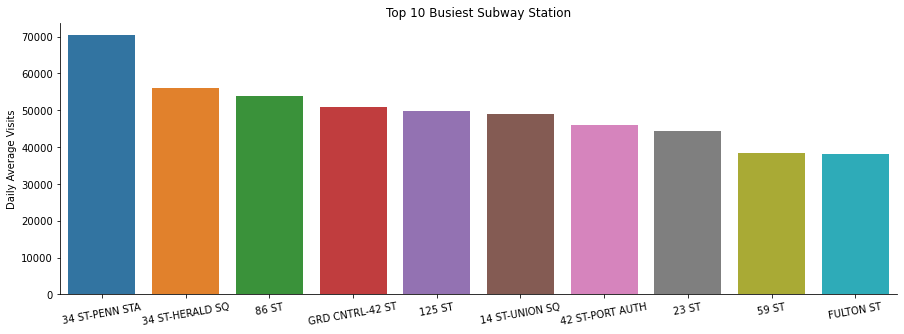

In [111]:
plt.figure(figsize=(15,5))
sns.barplot(x='STATION', y='AVG_DAILY', data=top10_avg_staition)
plt.title("Top 10 Busiest Subway Station")
plt.xticks(fontsize = '10', rotation = 10)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("Daily Average Visits", fontsize = '10')
sns.despine()
plt.savefig("top10_avg_daily_visit_staition.png", dpi = 200);

In [99]:
#weekday daily level
day_daily_sum = (daily.groupby(["DAY"], as_index=False)
                  .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
day_daily_sum

,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,0,44358303,21793286,22565017
1,1,44406091,21845479,22560612
2,2,44774030,22011693,22762337
3,3,44651294,21922996,22728298
4,4,45194671,22065647,23129024
5,5,29984544,13954331,16030213
6,6,22107394,10150762,11956632


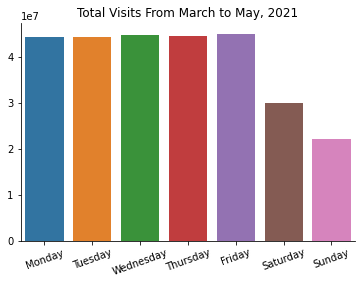

In [110]:
sns.barplot(x='DAY', y='SUM_DAILY', data=day_daily_sum)
plt.title("Total Visits From March to May, 2021")
plt.xticks(range(7), 
           ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 
           fontsize = '10', rotation = 20)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("")
sns.despine()
plt.savefig("total_visit_day.png", dpi = 200);

In [113]:
#sum_by_date level
sum_by_date = (daily.groupby(["DATE", "DAY"], as_index=False)
                        .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
sum_by_date

,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,2021-03-01,0,3108757,1544119,1564638
1,2021-03-02,1,3147439,1558745,1588694
2,2021-03-03,2,3300518,1633326,1667192
3,2021-03-04,3,3247911,1598966,1648945
4,2021-03-05,4,3276008,1608903,1667105
...,...,...,...,...,...
87,2021-05-27,3,3881996,1887119,1994877
88,2021-05-28,4,3723969,1799056,1924913
89,2021-05-29,5,2211674,1021995,1189679
90,2021-05-30,6,1713560,775882,937678


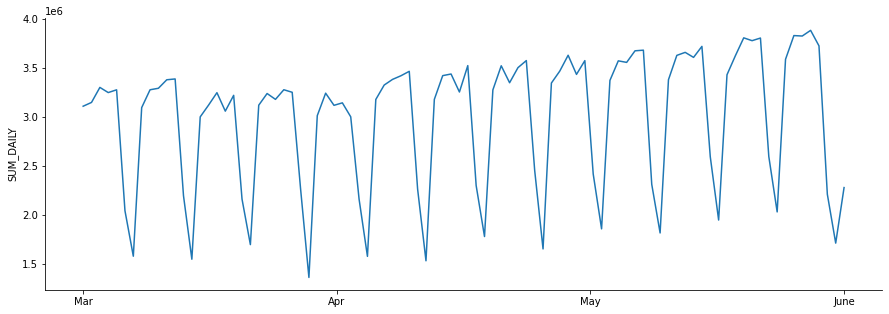

In [163]:
plt.figure(figsize=(15,5))
sns.lineplot(data=sum_by_date, x=sum_by_date.index, y="SUM_DAILY") 
#sns.regplot(data=sum_by_date, x=sum_by_date.index, y="SUM_DAILY")
plt.xticks(np.linspace(0,91,4), ['Mar', 'Apr', 'May', 'June'], fontsize = '10')
sns.despine()
plt.savefig("total_visit_by_date.png", dpi = 200);


In [175]:
#avg day visits
day_avg = (sum_by_date.groupby(["DAY"], as_index=False)
                      .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"mean", "EXITS_DAILY":"mean"})
                      .round()
                      .astype(int)
                      .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
day_avg

,DAY,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,0,3168450,1556663,1611787
1,1,3415853,1680421,1735432
2,2,3444156,1693207,1750949
3,3,3434715,1686384,1748331
4,4,3476513,1697357,1779156
5,5,2306503,1073410,1233093
6,6,1700569,780828,919741


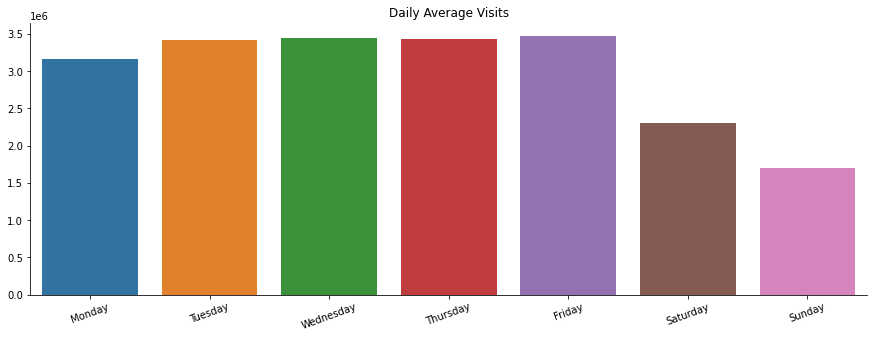

In [187]:
plt.figure(figsize=(15,5))
#sns.lineplot(x='DAY', y='AVG_DAILY', data=day_avg)
sns.barplot(x='DAY', y='AVG_DAILY', data=day_avg)
plt.title("Daily Average Visits")
plt.xticks(range(7), 
           ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 
           fontsize = '10', rotation = 20)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("", fontsize = '10')
sns.despine()
plt.savefig("avg_daily_visit_day.png", dpi = 200);

In [217]:
ca_daily.sort_values("SUM_DAILY", ascending=False).head(30)

,CA,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
42240,PTH22,PATH NEW WTC,2021-03-05,4,73418,37821,35597
42321,PTH22,PATH NEW WTC,2021-05-25,1,72614,35687,36927
40817,PTH03,JOURNAL SQUARE,2021-04-23,4,69679,39765,29914
40810,PTH03,JOURNAL SQUARE,2021-04-16,4,67162,38483,28679
40803,PTH03,JOURNAL SQUARE,2021-04-09,4,66224,37919,28305
40816,PTH03,JOURNAL SQUARE,2021-04-22,3,61120,36454,24666
42301,PTH22,PATH NEW WTC,2021-05-05,2,59789,32322,27467
40799,PTH03,JOURNAL SQUARE,2021-04-05,0,57557,33898,23659
40780,PTH03,JOURNAL SQUARE,2021-03-17,2,52819,30574,22245
42327,PTH22,PATH NEW WTC,2021-05-31,0,50953,27709,23244


In [212]:
#busiest CA and day
ca_daily_avg = (ca_daily.groupby(["CA", "STATION", "DAY"], as_index=False)
                      .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"})
                      .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
ca_daily_avg.sort_values("AVG_DAILY", ascending=False).head(30)
#ca_daily_avg[ca_daily_avg["STATION"]=="34 ST-PENN STA"]

,CA,STATION,DAY,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
4904,R533,FLUSHING-MAIN,4,32996.615385,230193,198763
4901,R533,FLUSHING-MAIN,1,32795.923077,229784,196563
4902,R533,FLUSHING-MAIN,2,32769.461538,230350,195653
4903,R533,FLUSHING-MAIN,3,32268.923077,226300,193196
4900,R533,FLUSHING-MAIN,0,31745.785714,237965,206476
3224,PTH22,PATH NEW WTC,4,31610.000000,205563,205367
3222,PTH22,PATH NEW WTC,2,31471.307692,208962,200165
3112,PTH03,JOURNAL SQUARE,4,31343.384615,225927,181537
3221,PTH22,PATH NEW WTC,1,30675.153846,199140,199637
2342,N324,JKSN HT-ROOSVLT,4,28450.538462,205722,164135


In [210]:
ca_daily_avg[ca_daily_avg["DAY"] > 4].sort_values("AVG_DAILY", ascending=False).head(10)

,CA,STATION,DAY,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
4905,R533,FLUSHING-MAIN,5,23439.230769,158945,145765
2343,N324,JKSN HT-ROOSVLT,5,20902.307692,141050,130680
4870,R528,JUNCTION BLVD,5,19215.769231,114363,135442
2665,N506,34 ST-HERALD SQ,5,18285.307692,98436,139273
4906,R533,FLUSHING-MAIN,6,17035.923077,113235,108232
3225,PTH22,PATH NEW WTC,5,16854.538462,103259,115850
3911,R221,14 ST-UNION SQ,5,15723.384615,74239,130165
4023,R238,GRD CNTRL-42 ST,5,15605.923077,77025,125852
2344,N324,JKSN HT-ROOSVLT,6,15556.307692,102641,99591
4871,R528,JUNCTION BLVD,6,14347.076923,83733,102779


In [215]:
daily[(daily["STATION"]=="FLUSHING-MAIN")].sort_values("SUM_DAILY", ascending=False).head(30)

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY
428271,R533,00-03-00,FLUSHING-MAIN,2021-05-25,17513197,15683100,17510898,15680540,2299,2560,4859,1
428274,R533,00-03-00,FLUSHING-MAIN,2021-05-28,17520420,15691435,17518095,15688963,2325,2472,4797,4
428273,R533,00-03-00,FLUSHING-MAIN,2021-05-27,17517888,15688563,17515600,15686061,2288,2502,4790,3
428260,R533,00-03-00,FLUSHING-MAIN,2021-05-14,17489633,15657223,17487417,15654811,2216,2412,4628,4
428258,R533,00-03-00,FLUSHING-MAIN,2021-05-12,17484858,15651679,17482619,15649299,2239,2380,4619,2
428270,R533,00-03-00,FLUSHING-MAIN,2021-05-24,17510748,15680173,17508500,15677849,2248,2324,4572,0
428266,R533,00-03-00,FLUSHING-MAIN,2021-05-20,17502572,15671009,17500277,15668735,2295,2274,4569,3
428265,R533,00-03-00,FLUSHING-MAIN,2021-05-19,17500095,15668317,17497868,15665996,2227,2321,4548,2
428259,R533,00-03-00,FLUSHING-MAIN,2021-05-13,17487250,15654358,17485011,15652091,2239,2267,4506,3
428195,R533,00-03-00,FLUSHING-MAIN,2021-03-10,17358209,15527227,17356045,15524908,2164,2319,4483,2
